**Intrinsic Growth Model with 1985 to 1990 data**

In [31]:
# most basic imports that I would need, need more to visualize
import numpy as np
import scipy as sp
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import category_encoders as ce
import xgboost as xgb
import matplotlib.pyplot as mpl




Next, must load the data!
t1 represents the data we are working on predicting, while t2 represents the expected values of the prediction. t2 will be used primarily for calculating the error

In [3]:

# load all data
raw_data_t1 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1985.csv")
raw_data_t2 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1990.csv")

# load the first quadrat that we will be working with
quad1_t1 = raw_data_t1.loc[raw_data_t1['quadrat']==1]
quad1_t2 = raw_data_t2.loc[raw_data_t2['quadrat']==1]

# we only care about the tree IDs and DBHs of quad1_t2
expected_labels = quad1_t2[['treeID', 'dbh']]
expected_labels = expected_labels.rename(columns={"dbh": "dbh2", "treeID": "treeID2"})

#quad1_t1.head()

/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_1033/3260900854.py:2: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data_t1 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1985.csv")
/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_1033/3260900854.py:3: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data_t2 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1990.csv")


Simplify data: extract important features. Next step: remove trees that are dead in either census, other cleaning this way to get rid of data errors. This could involve no species listed, or zero or NaN DBH. Later on, will need the actual date too.

In [4]:
# simplify the data to have less features
quad1_t1 = quad1_t1[['treeID', 'sp', 'gx', 'gy', 'dbh']]
quad1_t1 = quad1_t1.rename(columns={"dbh": "dbh1", "treeID":"treeID1"})

Create a list of all of the species present and index them in a list. 

NOTE: Now am exploring different ways to encode the species so that they are  ordered nominally!

Probably makes sense to use hash encoding because there are so many possible options for species (just in this one quadrat, 85 species are present)

In [5]:
encoder= ce.BinaryEncoder(cols=['sp'],return_df=True)
data_encoded=encoder.fit_transform(quad1_t1)

data_encoded.head()

,treeID1,sp_0,sp_1,sp_2,sp_3,sp_4,sp_5,sp_6,gx,gy,dbh1
8223,8224,0,0,0,0,0,0,1,1.6,24.700001,294.0
230867,230868,0,0,0,0,0,1,0,2.8,20.400000,NaN
230971,230972,0,0,0,0,0,1,1,0.3,24.100000,15.0
230972,230973,0,0,0,0,1,0,0,0.2,24.600000,25.0
230973,230974,0,0,0,0,1,0,1,0.8,24.700001,15.0


In [6]:
df_combined = pd.concat([data_encoded, expected_labels], axis=1)

# Drop rows with any NaN values
df_combined_clean = df_combined.dropna()

# Separate the cleaned DataFrame and labels
labels_clean = df_combined_clean[expected_labels.columns]
df_clean = df_combined_clean[['treeID1','sp_0','sp_1','sp_2','sp_3','sp_4','sp_5','sp_6', 'gx', 'gy', 'dbh1']]

In [7]:
# convert both from above (no null included) to numpy arrays
quad1_t1 = df_clean.to_numpy()
expected_labels = labels_clean.to_numpy()


In [8]:
# needed for data processing in next steps
quad1_t1 = quad1_t1.astype(np.float32)
expected_labels = expected_labels.astype(np.float32)

In [9]:
# change the labels so that they show GROWTH, not future DBH - better for readability of loss
expected_labels[:,1] = expected_labels[:,1] - quad1_t1[:,10]

In [10]:
# change any negative value to zero
expected_labels = np.where (expected_labels<0, 0, expected_labels)

In [11]:
# split into test and training sets
X_train, X_test, y_train, y_test = train_test_split(quad1_t1, expected_labels, test_size=0.3)
# print (X_train.dtype)

In [12]:
# then convert those numpy arrays to tensors - not yet needed
# X_train = torch.from_numpy(X_train)
# X_test = torch.from_numpy(X_test)
# y_train = torch.from_numpy(y_train)
# y_test = torch.from_numpy(y_test)

Using SKLearn's Random Forest Regressor

In [13]:
feats = np.column_stack((X_train[:,1:8], X_train[:,10:]))
#print (feats)
labels = y_train[:,1]
#print (labels)
test_feats = np.column_stack((X_test[:,1:8], X_test[:,10:]))

In [14]:
tree = RandomForestRegressor()
tree.fit(feats, labels)

RandomForestRegressor()

In [15]:
identifiers = X_test[:, 0]  
predictions = tree.predict(test_feats)
predictions_matrix = np.column_stack((identifiers, predictions))


In [16]:
error1 = sklearn.metrics.mean_squared_error(y_test[:,1], predictions)
print (np.sqrt(error1))
error1a = r2_score(y_test[:,1],predictions)
print (error1a)

24.743694184343585
0.17512493595002698


Using XGBoost's XGBRegressor:

In [17]:
tree2 = xgb.XGBRegressor()
tree2.fit(feats,labels)
predictions2 = tree2.predict(test_feats)
predictions_matrix = np.column_stack((identifiers, predictions2))
error2 = sklearn.metrics.mean_squared_error(y_test[:,1], predictions2)
print (np.sqrt(error2))
error2a = r2_score (y_test[:,1], predictions2)
print (error2a)


24.203423
0.21075348405430927


[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


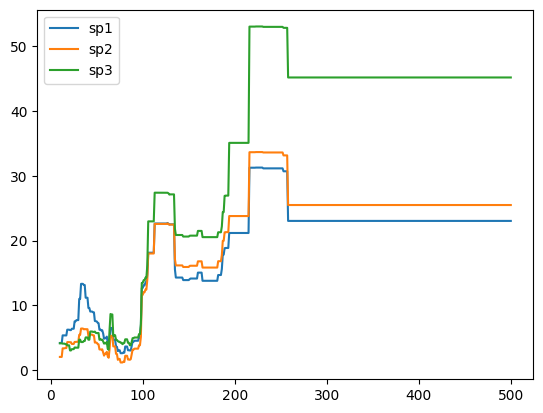

In [42]:
# Proof of concept for diagnostics for first species!

range = np.arange(10,501).transpose()
sp_label = np.atleast_2d(quad1_t1[0,1:8])
sp_repeated = np.repeat(sp_label,491,axis=0)
print (sp_repeated)
sp_1 = np.column_stack((sp_repeated,range))

predictions_sp1 = tree.predict(sp_1)
mpl.plot(range, predictions_sp1, label = "sp1")

sp_label2 = np.atleast_2d(quad1_t1[7,1:8])
sp_repeated2 = np.repeat(sp_label2,491,axis=0)
sp_2 = np.column_stack((sp_repeated2,range))

predictions_sp2 = tree.predict(sp_2)
mpl.plot(range, predictions_sp2, label = "sp2")

sp_label3 = np.atleast_2d(quad1_t1[9,1:8])
sp_repeated3 = np.repeat(sp_label3,491,axis=0)
sp_3 = np.column_stack((sp_repeated3,range))

predictions_sp3 = tree.predict(sp_3)
mpl.plot(range, predictions_sp3, label = "sp3")

mpl.legend()



In [40]:
encoder.inverse_transform(sp_label)

ValueError: The count of the column names does not correspond to the count of the columns

Now, attempt to do so for allll species. Need to start by reloading everything!

In [46]:

# load all data
raw_data_t1 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1985.csv")
raw_data_t2 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1990.csv")

# we only care about the tree IDs and DBHs of quad1_t2
expected_labels = raw_data_t2[['treeID', 'dbh']]
expected_labels = raw_data_t2.rename(columns={"dbh": "dbh2", "treeID": "treeID2"})

#quad1_t1.head()
# simplify the data to have less features
quad1_t1 = raw_data_t1[['treeID', 'sp', 'gx', 'gy', 'dbh']]
quad1_t1 = raw_data_t1.rename(columns={"dbh": "dbh1", "treeID":"treeID1"})

/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_1033/2664221453.py:2: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data_t1 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1985.csv")
/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_1033/2664221453.py:3: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data_t2 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1990.csv")


In [ ]:
species_list = []

for i in quad1_t1.index:
    current = quad1_t1['sp'][i] 
    print (current)
    if current not in species_list:
            species_list.append(current)
    quad1_t1['sp'][i]  = species_list.index(current)

    print (len(species_list))
    quad1_t1.head(30)
    print(species_list)
    quad1_t1.head()

list_df = pd.DataFrame(species_list)

encoder= ce.BinaryEncoder(cols=['sp'],return_df=True)
quad1_t1 = encoder.fit_transform(quad1_t1)
df_combined = pd.concat([quad1_t1, expected_labels], axis=1)

#then also need to encode that species list? and know that the index of the species corresponds?
# need to turn list into an array first? need to use same encoder? 

# Drop rows with any NaN values
df_combined_clean = df_combined.dropna()




# Separate the cleaned DataFrame and labels
df_clean = df_combined_clean[quad1_t1.columns]
labels_clean = df_combined_clean[expected_labels.columns]

quad1_t1 = df_clean.to_numpy()
expected_labels = labels_clean.to_numpy()

quad1_t1 = quad1_t1.astype(np.float32)
expected_labels = expected_labels.astype(np.float32)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:




encoder= ce.BinaryEncoder(cols=['sp'],return_df=True)

data_encoded=encoder.fit_transform(quad1_t1)

data_encoded.head()

# arange from 10 to 500

# hstack